## Importing libraries

In [ ]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
#import scipy.io as sio
from matplotlib import pyplot as plt
import matplotlib.cm as cm
#----------------------------
# scikit-learn
#----------------------------
# clustering
from sklearn.cluster import KMeans
# preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
# metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [ ]:
#use numpy fixed point notation
np.set_printoptions(suppress=True)
#----------------------------
# disable convergence warning
#from sklearn.utils.testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning
#----------------------------
# path to save figures
path = '../figures/k-means/'

# Reading the dataset (.mat file)

## Preprocessing

In [464]:
input_cols = [
#     'SG_UF_RESIDENCIA', 
#     'NU_IDADE', 
#     'TP_SEXO',
#     'TP_COR_RACA', 
#     'TP_NACIONALIDADE', 
#     'SG_UF_NASCIMENTO', 
#     'TP_ST_CONCLUSAO', 
#     'TP_ANO_CONCLUIU', 
#     'TP_ESCOLA', 
#     'TP_ENSINO', 
#     'IN_TREINEIRO',
#     'IN_BAIXA_VISAO', 
#     'IN_CEGUEIRA', 
#     'IN_SURDEZ', 
#     'IN_DEFICIENCIA_AUDITIVA', 
#     'IN_SURDO_CEGUEIRA',
#     'IN_DEFICIENCIA_FISICA', 
#     'IN_DEFICIENCIA_MENTAL', 
#     'IN_DEFICIT_ATENCAO', 
#     'IN_DISLEXIA', 
#     'IN_DISCALCULIA',
#     'IN_AUTISMO', 
#     'IN_VISAO_MONOCULAR', 
#     'IN_OUTRA_DEF', 
#     'IN_ESTUDA_CLASSE_HOSPITALAR', 
#     'IN_SEM_RECURSO',
#     'TP_PRESENCA_CN', 
#     'TP_PRESENCA_CH',
#     'TP_PRESENCA_LC', 
#     'TP_PRESENCA_MT',
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 
    'Q024', 'Q025', 'Q026', 'Q027',
    
    'NU_NOTA_REDACAO',
    'NU_NOTA_CN', 
    'NU_NOTA_CH', 
    'NU_NOTA_LC', 
    'NU_NOTA_MT',
]

#output_cols = ['NU_NOTA_REDACAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']

In [465]:
from os.path import abspath, join
# get the root dir ('current_dir/..')
root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')

In [466]:
import zipfile
# set dataset files path
file_path = join(dataset_dir, 'microdados_enem2018.zip')
# read zip files
zf = zipfile.ZipFile(file_path)
#df = pd.read_csv(zf.open('DADOS/MICRODADOS_ENEM_2018.csv'), sep=';', encoding='cp1252')
data = pd.read_csv(zf.open('DADOS/MICRODADOS_ENEM_2018.csv'), sep=';', encoding='cp1252', usecols=input_cols).dropna()

## Socioeconomic questionnaire

The socioeconomic questionnaire has categorical values. We will encode them using the well-known one-hot-encoding. For binary values, we will map them in 0 or 1.

|Column|Values |
|:----:|:----:|
|Q001,Q002|A-H|
|Q003,Q004|                  A-F|
|Q005|                       1-20 (Numeric)|
|Q006|                       A-Q| 
|Q007,Q026|                  A-D|
|Q008-17,Q019,Q022,Q024|     A-E|
|Q018,Q020-21,Q023,Q025|     A-B  (Codification A=0, B=1)|
|Q027|                       A-F|


In [467]:
one_hot_socio = ['Q001','Q002','Q003','Q004','Q006',
         'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
         'Q015','Q016','Q017','Q019','Q022','Q024','Q026','Q027',
]
encode_socio = {
    'Q018':{'A':0,'B':1},
    'Q020':{'A':0,'B':1},
    'Q021':{'A':0,'B':1},
    'Q023':{'A':0,'B':1},
    'Q025':{'A':0,'B':1}
}

In [468]:
## Scaling the scores

In [469]:
# redacao_scaler = StandardScaler()
# CN_scaler = StandardScaler()
# CH_scaler = StandardScaler()
# LC_scaler = StandardScaler()
# MT_scaler = StandardScaler()

# data['NU_NOTA_REDACAO'] = redacao_scaler.fit_transform(data['NU_NOTA_REDACAO'].to_numpy().reshape(-1,1))
# data['NU_NOTA_REDACAO'] = redacao_scaler.fit_transform(data['NU_NOTA_REDACAO'].to_numpy().reshape(-1,1))
# data['NU_NOTA_CN'] = CN_scaler.fit_transform(data['NU_NOTA_CN'].to_numpy().reshape(-1,1))
# data['NU_NOTA_CH'] = CH_scaler.fit_transform(data['NU_NOTA_CH'].to_numpy().reshape(-1,1))
# data['NU_NOTA_LC'] = LC_scaler.fit_transform(data['NU_NOTA_LC'].to_numpy().reshape(-1,1))
# data['NU_NOTA_MT'] = MT_scaler.fit_transform(data['NU_NOTA_MT'].to_numpy().reshape(-1,1))

### Filtering
Removing the data from which the answer to questions Q001, Q002, Q003 and Q004 is "I don't know.".

|Column|Option "I don't know."|
|:----:|:----:|
|Q001|H|
|Q002|H|
|Q003|F|
|Q004|F|

In [470]:
print('Inputs before filtering{}'.format(data.shape))

data.drop(data[(data['Q001']=="H") | (data['Q002']=="H")|(data['Q003']=="F") | (data['Q004']=="F")].index, inplace=True)
# Standard Scaler
Q005_scaler = StandardScaler()
data['Q005'] = Q005_scaler.fit_transform(data['Q005'].to_numpy().reshape(-1,1))

print('Inputs after filtering {}'.format(data.shape))

Inputs before filtering(3893739, 16)
Inputs after filtering (3087813, 16)


## Applicant information

In [471]:
one_hot_participante = [
#    'TP_ESTADO_CIVIL',
    'TP_COR_RACA',
#    'SG_UF_NASCIMENTO',
#    'TP_NACIONALIDADE',
    'TP_ST_CONCLUSAO',
#    'TP_ANO_CONCLUIU',
    'TP_ESCOLA',
    'TP_ENSINO',
    'IN_TREINEIRO'
]

encode_participante = {'TP_SEXO':{'M':0, 'F':1}}

### Standard Scaler

In [472]:
# idade_scaler = StandardScaler()
# data['NU_IDADE'] = idade_scaler.fit_transform(data['NU_IDADE'].to_numpy().reshape(-1,1))

### Filtering

Information relative to the name of cities will be removed.
"Dirty data" such as answers like "non informed" will also be removed.
And applicants that realized the exam just as a training, will be removed too.

In [473]:
# print('Inputs before filtering{}'.format(data.shape))

# if 'NO_MUNICIPIO_RESIDENCIA' in data.columns:
#     data.drop(['NO_MUNICIPIO_RESIDENCIA'], axis=1, inplace=True)

# if 'NO_MUNICIPIO_NASCIMENTO' in data.columns:
#     data.drop(['NO_MUNICIPIO_NASCIMENTO'], axis=1, inplace=True)

# if 'IN_TREINEIRO' in data.columns:
#     data.drop(data[data['IN_TREINEIRO']==1].index, inplace=True)
#     data.drop(['IN_TREINEIRO'], axis=1, inplace=True)

# if 'SG_UF_RESIDENCIA' in data.columns:
#     data.drop(data[data['SG_UF_RESIDENCIA']!="SP"].index, inplace=True)
#     data.drop(['SG_UF_RESIDENCIA'], axis=1, inplace=True)

# if 'SG_UF_NASCIMENTO' in data.columns:
#     data.drop(['SG_UF_NASCIMENTO'], axis=1, inplace=True)

# data.drop(data[(data['TP_NACIONALIDADE']==0)].index, inplace=True)    

# print('Inputs after filtering {}'.format(data.shape))    

### Removing column "Specialized resources"

In [474]:
if 'IN_SEM_RECURSO' in data.columns:
    data.drop(['IN_SEM_RECURSO'], axis=1, inplace=True)

In [475]:
one_hot_prova = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']
one_hot_cols = set(data.columns).intersection(one_hot_socio + one_hot_participante + one_hot_prova)
input_cols_ = set(input_cols).intersection(data.columns)

In [476]:
# Dataframe de entrada
df_inp = pd.get_dummies(data[input_cols_], columns=set(one_hot_cols).intersection(input_cols_))
df_inp = df_inp.replace({**encode_participante, **encode_socio})

In [477]:
kmeans = KMeans(
    n_clusters = 8, 
    init = 'k-means++', 
    n_init = 10, 
    max_iter = 300, 
    tol = 0.0001, 
    precompute_distances = 'auto', 
    verbose = 0, 
    random_state = None, 
    copy_x = True, 
    n_jobs = None, 
    algorithm = 'auto',
)
# save parameters
parameters = kmeans.get_params()

In [478]:
raw_X = df_inp[:10000]

## PCA

In [497]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(raw_X)
#print(pca.explained_variance_)
X = pca.fit_transform(raw_X)

## Kernel PCA

In [502]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=1e-9, degree=5)
#kpca.fit(raw_X)
#print(kpca.explained_variance_ratio_)  
X = kpca.fit_transform(raw_X)
range_n_clusters = range(2,11)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## ICA

In [337]:
from sklearn.decomposition import fastica
ica = fastica(raw_X, n_components=2)

## Gaussian Mixture

In [498]:
#X=raw_X

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5)
#print(gm.aic(X))
#print(gm.bic(X))
gm.fit_predict(X)

range_n_clusters = range(2,10)
#kmeans.fit(X)

## Testing the model

In [490]:
X = raw_X
range_n_clusters = range(2,21)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

For n_clusters = 2 The average silhouette_score is : 0.4052769826887399
For n_clusters = 3 The average silhouette_score is : 0.35836251344149833
For n_clusters = 4 The average silhouette_score is : 0.3119270148150963
For n_clusters = 5 The average silhouette_score is : 0.3111976834169207
For n_clusters = 6 The average silhouette_score is : 0.29055046313771765
For n_clusters = 7 The average silhouette_score is : 0.3025948135423071
For n_clusters = 8 The average silhouette_score is : 0.2886448915522299
For n_clusters = 9 The average silhouette_score is : 0.27507487134445685
For n_clusters = 10 The average silhouette_score is : 0.26983965870126614


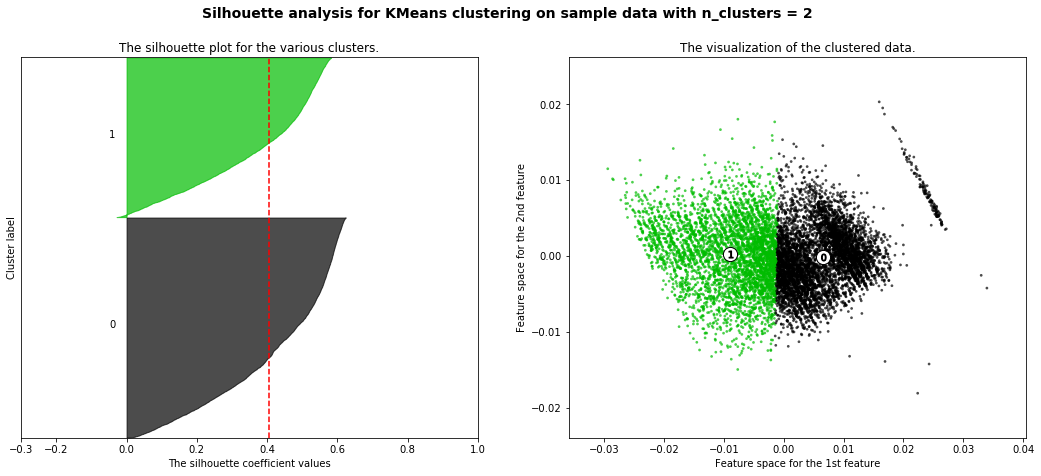

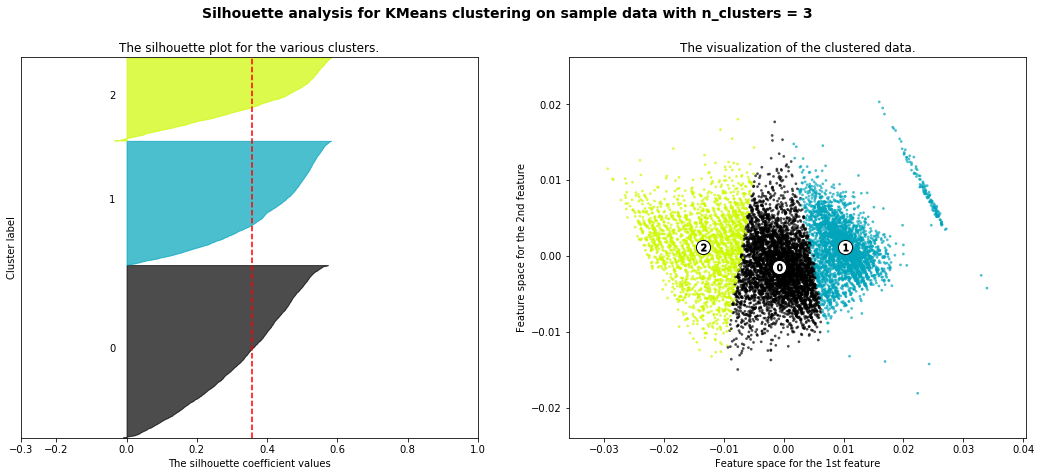

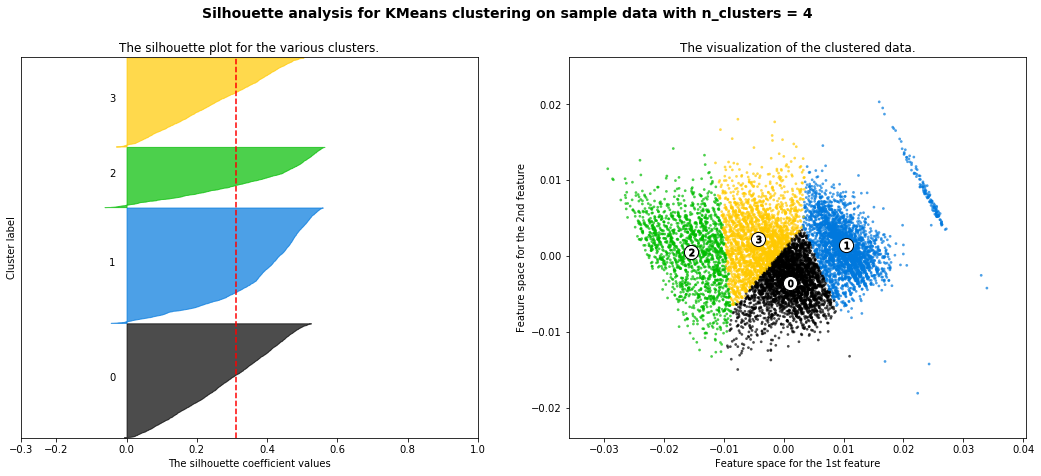

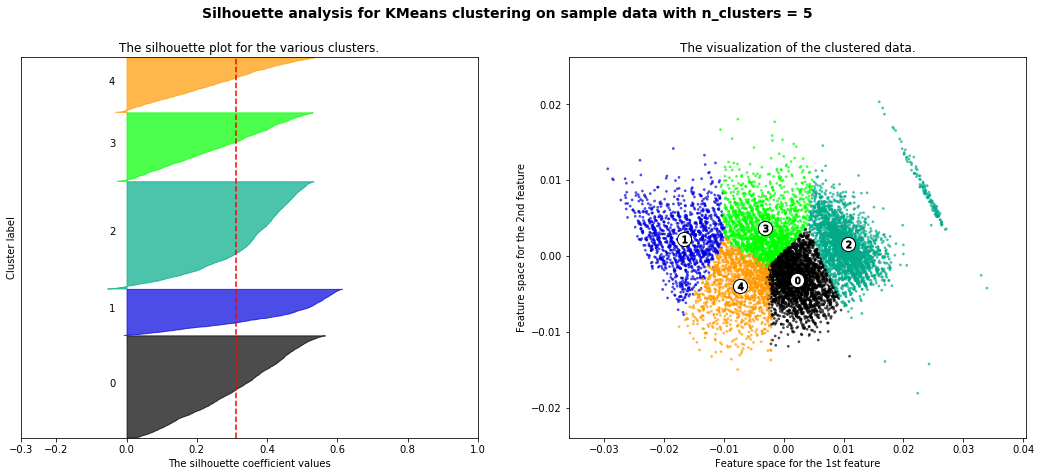

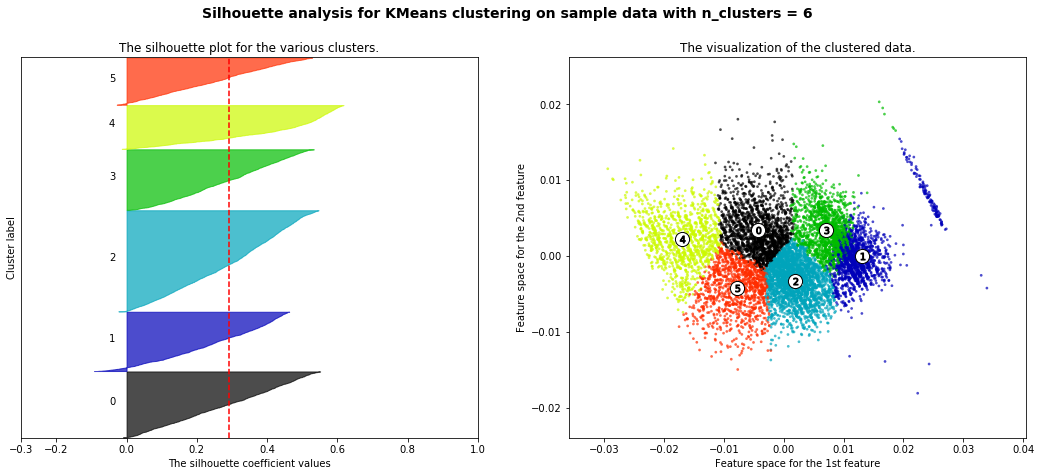

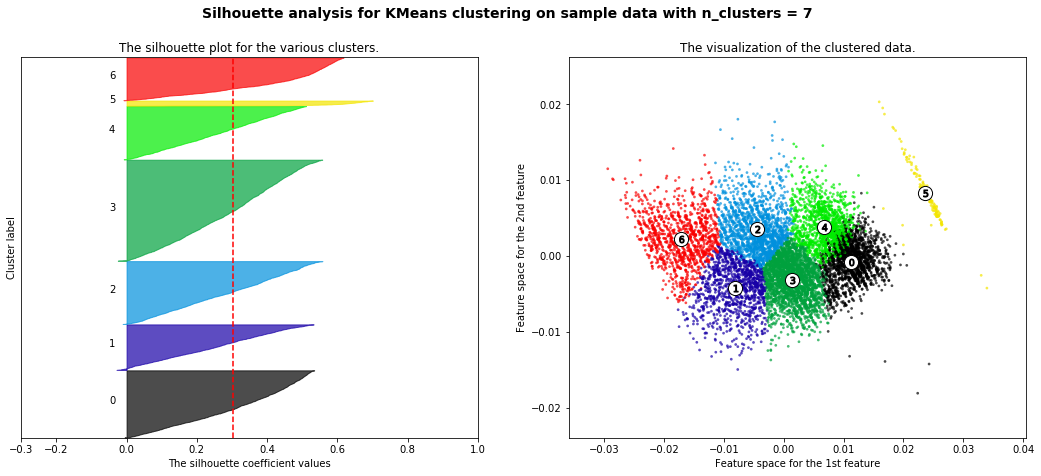

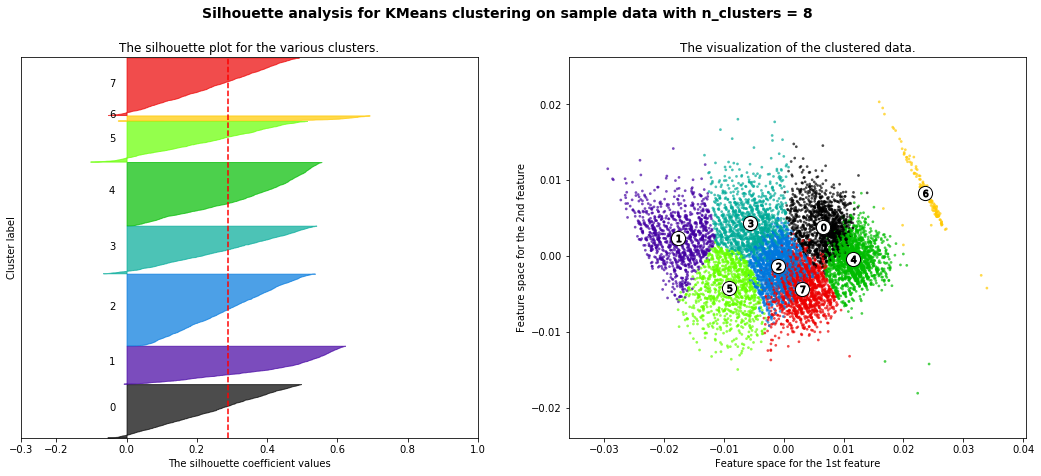

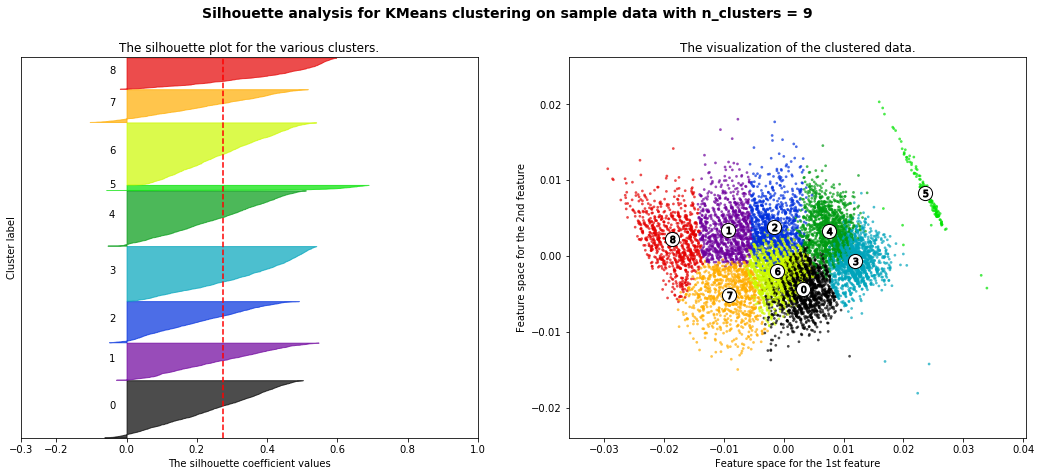

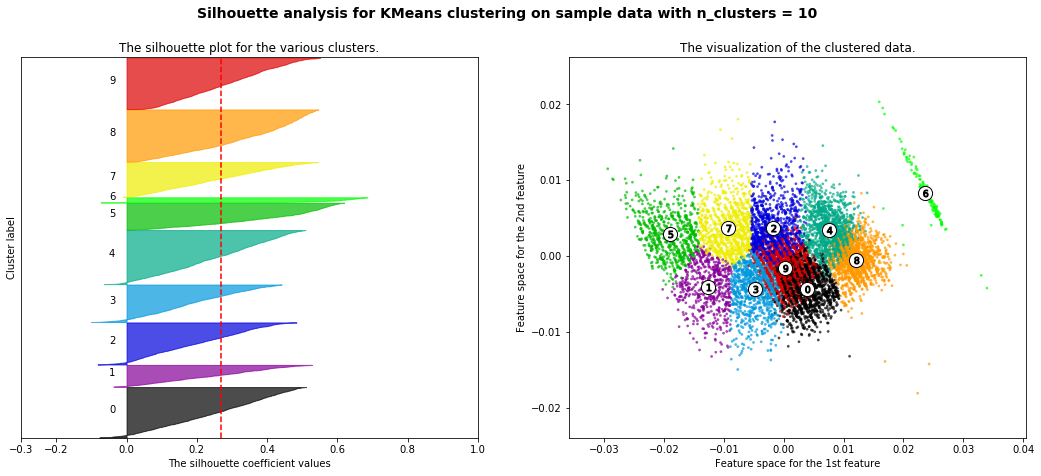

In [503]:
# Sweep number of clusters (hyperparameter)
for n_clusters in range_n_clusters:
    # get figure and axis to plot the silhouette coefficient
#    fig, ax = plt.subplots()
    fig, (ax, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1
    ax.set_xlim([-0.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # restore parameters changing only the number of clusters
    parameters['n_clusters'] = n_clusters
    clusterer = KMeans(**parameters)
#    clusterer = GaussianMixture(n_components=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    
    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Sweep inside clusters to perform the silhouette plot
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        # size of the cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        # prepare the plot
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.3, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #-----------------------------------------------------------------------------------------
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Gaussian Mixture
#    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

    plt.savefig(path + 'kpca_silhouette_' + str(n_clusters) + '_clusters', dpi=300)
    
plt.show()